#### Introduction
This program analyses a set of weekly results for a parkrun event, outputting a scatter plot of the finishing position against finish time and also a histogram plot of number of finishers each minute. 

**Pandas** is used for data processing and **Matplotlib** is used for the graphical outputs. The input dataset is in a cleaned .csv format.



In [1]:
#Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt


#### Functions to round up or down to nearest 5

On the output plots (both with Time in minutes on the x axis) the viewable x axis will be rounded up to the 
next 5 minute multiple after the last datapoint and down to the previous 5 minute multiple before the first data point.

Functions are defined here in order to facilitate this each taking 2 arguments: 

- 'num' : The number to be rounded
- 'base': The 'multiple' to round to 

In [2]:
#function to round number down to nearest given multiple(base)
def round_down(num,base):
    return int(num/base)*base

#function to round number up to nearest given multiple(base)
def round_up(num,base):
    return (int(num/base)+1)*base

#### Load dataset and display as dataframe

Dataset is read from a .csv file and then converted to a Dataframe (df). The format of the filename must be 
**'[Event name]_[Event No]_DDMMYYYY.csv'**
so that details of event, event number and date can be extracted and used later.

Example format of data in .csv file:
```
POSITION,PARKRUNNER,GENDER,AGE GROUP,CLUB,TIME
1,Anon RUNNER,Male,SM25-29,Running Club,00:17:59
2,Anon RUNNER,Male,VM35-39,Running Club,00:18:46
3,Anon RUNNER,Male,SM25-29,Running Club,00:18:49
4,Anon RUNNER,Male,VM55-59,Running Club,00:19:01
```

In [3]:
#read week results from csv '[Event name]_[Event No]_DDMMYYYY'
filename="ExampleEvent_001_01012000.csv"
df = pd.read_csv(filename)
df

#test output
df

,POSITION,PARKRUNNER,GENDER,AGE GROUP,CLUB,TIME
0,1,Anon RUNNER,Male,SM25-29,Running Club,00:17:59
1,2,Anon RUNNER,Male,VM35-39,Running Club,00:18:46
2,3,Anon RUNNER,Male,SM25-29,Running Club,00:18:49
3,4,Anon RUNNER,Male,VM55-59,Running Club,00:19:01
4,5,Anon RUNNER,Male,VM35-39,Running Club,00:19:16
...,...,...,...,...,...,...
301,302,Anon RUNNER,Female,SW25-29,Running Club,00:56:12
302,303,Anon RUNNER,Female,VW40-44,Running Club,00:57:07
303,304,Anon RUNNER,Female,VW55-59,Running Club,00:57:07
304,305,Anon RUNNER,Female,VW35-39,Running Club,00:57:10


#### Keep Only Required Columns
All we need for analysis of finish times are the Position and Time columns so the rest of the dataframe can be dropped.

Doing this simply using ```df = df[["POSITION","TIME"]]``` raises a **'SettingWithCopyWarning'** later, when performing operations on a sliced dataframe so instead, ```.loc[row_indexer,col_indexer]``` is used, which selects all rows of the given columns to replace the existing dataframe.


In [4]:
##select columns to include in analysis. '.loc' prevents inconsistencies later from formatting sliced dataframes
df = df.loc[:,["POSITION","TIME"]]

#test output
df

,POSITION,TIME
0,1,00:17:59
1,2,00:18:46
2,3,00:18:49
3,4,00:19:01
4,5,00:19:16
...,...,...
301,302,00:56:12
302,303,00:57:07
303,304,00:57:07
304,305,00:57:10


#### Convert Time column to show time in total minutes
The time values are converted to Datetime format, specifying that they're currently text strings in the format **Hours:Minutes:Seconds**
A t_zero time instance is then created, which is also converted to Datetime and then subtracted from each time value 
to result in the time column being in timedelta format. Time in total minutes is then calculated.

In [5]:
#Reformat TIME column to datetime
df['TIME']=pd.to_datetime(df['TIME'], format='%H:%M:%S')

#Change Time column to time in total minutes
t_zero=pd.to_datetime('00:00:00', format='%H:%M:%S') # Creates t_zero time instance 
df['TIME']=df['TIME']-t_zero                         # subtracts t_zero to make the time column a timedelta
df['TIME']=df['TIME'].dt.total_seconds()/60          # calculates total minutes in the timedelta

#test output
df

,POSITION,TIME
0,1,17.983333
1,2,18.766667
2,3,18.816667
3,4,19.016667
4,5,19.266667
...,...,...
301,302,56.200000
302,303,57.116667
303,304,57.116667
304,305,57.166667


#### Generate event specifics by slicing filename string and obtaining dataframe length

Several string variables are extracted here to avoid having to enter them manually on graphs later. Filename must be in the correct format(**'[Event name]_[Event No]_DDMMYYYY.csv'**). 

Event, Event number and Date are taken by splitting the filename into a list of its components, using the underscore as the seperator. Further slicing is required on the characters of the date component to seperate day, month and year, remove the '.csv' and insert "/" between them on the date string.

The number of rows (length) of the dataframe gives the total number of finishers. This allows 'Unknown' runners to be included in the count, as they will not have a time assigned and so won't be included on graphical outputs.


An **f-string**  is then constructed, which includes these extracted stings and will be used as a label for legends on the graphs.

In [6]:
#extract variables from filename and dataframe which wil be used in plot text
spl= filename.split("_") #splits filename into list of its components
event = spl[0]
event_no = spl[1]

day= spl[2][0:2]
month=spl[2][2:4]
year=spl[2][4:8]
date= str(day)+"/"+str(month)+"/"+str(year) #concatenation to include "/" in date string

finishers=len(df) #all finishers, including unknowns

#f-string to create label to be used in legend
data_label=f"{event}, {date}, {finishers} finishers"

#test output
print("label:",data_label)

label: ExampleEvent, 01/01/2000, 306 finishers


#### Position v Time scatter plot
 
A titled figure is created, specifying number of rows and columns of axes. This makes multiple axes layout easy to arrange though only 1 is needed in this case. x,y data for the plot is then specified before plotting the scatter data. Various customisations are then made for the presentation of the plot.

 ```#set range of x axis``` makes use of the rounding functions to ensure x axis is wide enough to see all data and that axis limits are rounded to multiples of 5.

 **Required tick marks** are added by specifying an interval for a tick type (x,y, major or minor)  and then creating a list of specific values over the range of a given axis, with that interval.

 **Gridlines** are then added for easier reading of the data points

 

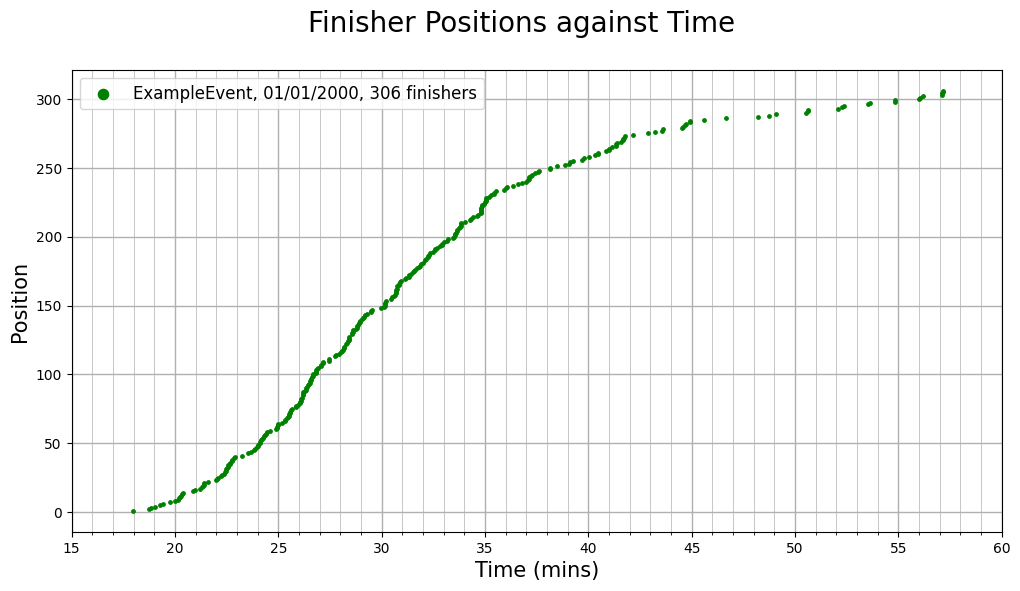

In [7]:
#figure and scatter subplot layout
rows, cols = 1, 1 #only 1 plot required in this case
fig, ax = plt.subplots(rows,cols, figsize=(12,6))
fig.suptitle('Finisher Positions against Time', fontsize=20)

#plot scatter data
x=df['TIME']
y=df['POSITION']
ax.scatter(x,y, s=6, color='green', label = data_label) #creates scatterplot data

#---------- Plot Customisations-----------

#axis labels
ax.set_xlabel ('Time (mins)',fontsize = 15)
ax.set_ylabel ('Position',fontsize = 15)

# apply legend to label dataset 
plt.legend(fontsize = 12, markerscale=3)

#set range of x axis
x_max = round_up(df['TIME'].max(),5)
x_min = round_down(df['TIME'].min(),5)
ax.set_xlim(left=x_min,right=x_max)

#set major x ticks at 5 minute intervals
xtick_interval_major=5
ax.set_xticks(list(range(x_min,x_max+1,xtick_interval_major)))

# set minor x ticks at 1 minute intervals
xtick_interval_minor=1
ax.set_xticks(list(range(x_min,x_max+1,xtick_interval_minor)),labels=None,  minor=True,)

#select to show grid with major gridlines thicker than minor
ax.grid(visible=True, which = 'major', linewidth=1)
ax.grid(visible=True, which = 'minor',linewidth=0.5)
ax.set_axisbelow(True) #ensures data points appear infront of gridlines




#### Histogram of 'Finishers Each Minute'
A titled figure is created, specifying number of rows and columns of axes. 

 ```#set range of x axis``` makes use of the rounding functions to ensure x axis is wide enough to see all data and that axis limits are rounded to multiples of 5.

 ##### Setting bin size
 When plotting the histogram, the locations of the bin boundaries are required(unless default values are okay) so these need to be calculated for the desired bin width. ```binwidth``` (in minutes) is specified as 1 and then the locations of the first and last bins. These values are then used to generate the list of values required for the ```bins``` argument when plotting the histogram data with ```ax.hist```

A **subtitle** f-string is added under the main title to inform the reader of the bin size.

  **Required tick marks** are added using the same methods as for the scatterplot and **gridlines** are then added on both axes.


Text(0.5, 0, 'Time (Mins)')

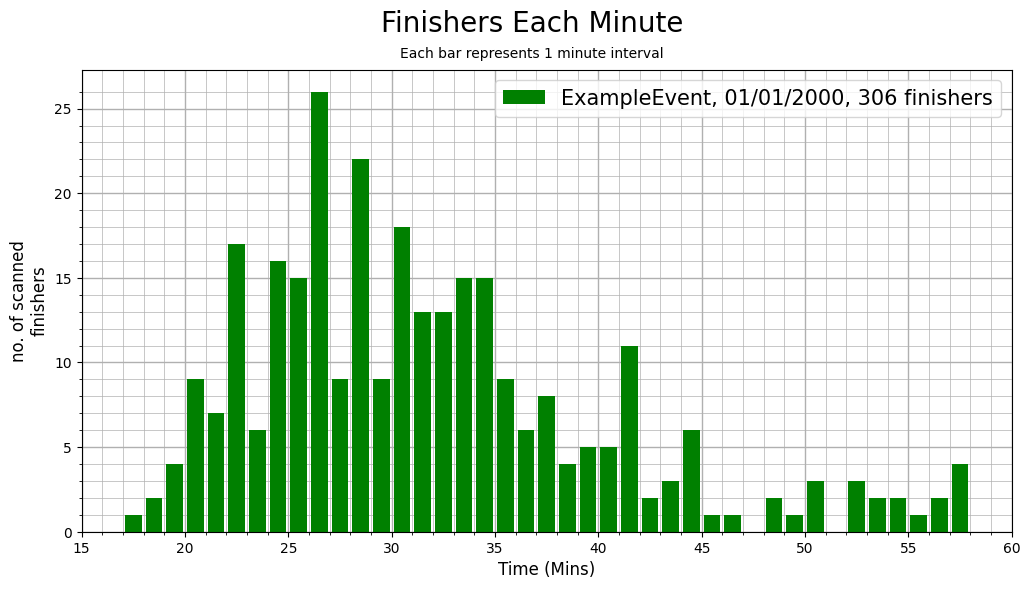

In [8]:
#figure and histogram subplot layout
rows, cols = 1, 1 #only 1 plot required in this case
fig, ax = plt.subplots(rows,cols, figsize=(12,6))
fig.suptitle('Finishers Each Minute', fontsize=20)

#set range of x axis
x_max = round_up(df['TIME'].max(),5)
x_min = round_down(df['TIME'].min(),5)
ax.set_xlim(left=x_min,right=x_max)

#set bin parameters
binwidth=1 #width of each bin in minutes
binmax=int(x_max+2)
binmin=int(x_min-1)

ax.hist(df['TIME'],
               color='green',
               rwidth=0.8,
               label= data_label,
               bins=list(range(binmin,binmax,binwidth)))

#create subtitle
fig.text(0.5, 0.9, f"Each bar represents {binwidth} minute interval", horizontalalignment="center", fontsize = 10)

# apply legend()
ax.legend(fontsize = 15, markerscale=4)

#set major x ticks at 5 minute intervals
xtick_interval_major=5
ax.set_xticks(list(range(x_min,x_max+1,xtick_interval_major)))

# set minor x ticks at 1 minute intervals
xtick_interval_minor=1
ax.set_xticks(list(range(x_min,x_max+1,xtick_interval_minor)),labels=None,  minor=True)

# set minor y ticks at count interval of 1
ytick_interval_minor=1
y_axis_top=int(max(ax.get_ylim())) # returns integer value of top of viewable y axis
ax.set_yticks(list(range(0,y_axis_top,ytick_interval_minor)),
              labels=None,
              minor=True) #ensures minor ticks cover range of y axis view

#select to show grid with major gridlines thicker than minor
ax.grid(visible=True, which = 'major', linewidth=1,axis='both')
ax.grid(visible=True, which = 'minor',linewidth=0.5,axis='both')
ax.set_axisbelow(True) #ensures data points appear infront of grid

#set  axis labels
ax.set_ylabel('no. of scanned\nfinishers', fontsize = 12)
ax.set_xlabel('Time (Mins)',fontsize = 12)
